<a href="https://colab.research.google.com/github/AttentiveNader/grayscale-to-rgb-/blob/main/grayscale_to_rgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
from torchvision.datasets import CelebA, WIDERFace
import glob
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from sklearn.metrics import confusion_matrix
from PIL import Image
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
!wget 'http://chaladze.com/l5/img/Linnaeus 5 64X64.rar' \ -O dataset.rar
!pip install unrar
!unrar x '/content/Linnaeus 5 64X64.rar'

Streaming output truncated to the last 5000 lines.
Extracting  Linnaeus 5 64X64/train/berry/825_64.jpg                       38%  OK 
Extracting  Linnaeus 5 64X64/train/berry/826_64.jpg                       38%  OK 
Extracting  Linnaeus 5 64X64/train/berry/827_64.jpg                       38%  OK 
Extracting  Linnaeus 5 64X64/train/berry/828_64.jpg                       38%  OK 
Extracting  Linnaeus 5 64X64/train/berry/829_64.jpg                       38%  OK 
Extracting  Linnaeus 5 64X64/train/berry/82_64.jpg                        38%  OK 
Extracting  Linnaeus 5 64X64/train/berry/830_64.jpg                       38%  OK 
Extracting  Linnaeus 5 64X64/train/berry/831_64.jpg                       38%  OK 
Extracting  Linnaeus 5 64X64/train/berry/832_64.jpg                       38%  OK 
Extracting  Linnaeus 5 64X64/train/berry/833_64.jpg                       38%  OK 
Extracting  Linnaeus 5 64X64/

In [ ]:
class L5Dataset(torch.utils.data.Dataset):

  def __init__(self, paths):
    self.images = paths
  
  def __getitem__(self,idx):

    img = Image.open(self.images[idx])
    gray = transforms.functional.to_tensor(transforms.functional.to_grayscale(img))
    img = transforms.functional.to_tensor(img)
    return {
        "image": gray,
        "target" : img
    }
  def __len__(self,):
    return len(self.images)

In [ ]:
train = glob.glob("/content/Linnaeus 5 64X64/train/dog/*.jpg")[:1200] # 1200
train = train + glob.glob("/content/Linnaeus 5 64X64/train/flower/*.jpg")[:1200] # 1200
train = train + glob.glob("/content/Linnaeus 5 64X64/train/bird/*.jpg")[:1200] # 1200
train = train + glob.glob("/content/Linnaeus 5 64X64/train/berry/*.jpg")[:1200] # 1200
train = train + glob.glob("/content/Linnaeus 5 64X64/train/other/*.jpg")[:1200] # 1200

train += glob.glob("/content/Linnaeus 5 64X64/test/dog/*.jpg") # 1200
train = train + glob.glob("/content/Linnaeus 5 64X64/test/flower/*.jpg") # 1200
train = train + glob.glob("/content/Linnaeus 5 64X64/test/bird/*.jpg") # 1200
train = train + glob.glob("/content/Linnaeus 5 64X64/test/berry/*.jpg") # 1200
train = train + glob.glob("/content/Linnaeus 5 64X64/test/other/*.jpg") # 1200
dataset = L5Dataset(train)

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        # channels_in ,  channels_out, kernel_size, stride , padding,
        self.conv1 = nn.Conv2d(1, 64,3,1,1, bias =False)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64,64,3,1,1,bias =False)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64,64,4,2,1)
        self.conv4 = nn.Conv2d(64,128,4,2,1)
        self.maxp1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.maxp2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.maxp3 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.maxp4 = nn.MaxPool2d(kernel_size=2,stride=2)


        
    def forward(self,x):
        out = self.conv1(x)
        out = self.maxp1(out)
        out = self.batchnorm1(out)
        out = F.relu(out) 
        out = self.conv2(out)
        out = self.maxp2(out)
        out = self.batchnorm2(out)
        out = F.relu(out)
        out = self.conv3(out)
        out = self.maxp3(out)
        out = F.relu(out)
        out= self.conv4(out)
        out = self.maxp4(out)
        out = F.relu(out)
        return out.view(out.shape[0],-1)
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        # channels_in ,  channels_out, kernel_size, stride , padding,
        """
        convtranspose  is different from the regular conv layer (looking at the equations of two of them )
        this link shows examples about it 
        https://towardsdatascience.com/is-the-transposed-convolution-layer-and-convolution-layer-the-same-thing-8655b751c3a1
        
        """
        self.transconv1 = nn.ConvTranspose2d(128 ,64,8,4,2)
        self.transconv2 = nn.ConvTranspose2d(64,64,8,4,2)
        self.transconv3 = nn.ConvTranspose2d(64,64,4,2,1)
        self.transconv4 = nn.ConvTranspose2d(64,3,4,2,1)
        
      

        
    def forward(self,x):
        
        out= self.transconv1(x.view(x.shape[0],x.shape[1],1,1))
        out = F.relu(out)
        out= self.transconv2(out)
        out = F.relu(out)

        out= self.transconv3(out)
        out = F.relu(out)

        out= self.transconv4(out)
        out = F.relu(out)

        return out
        
class AE(nn.Module):
    def __init__(self,encoder,decoder):
        super(AE,self).__init__()
        self.encoder = encoder()
        self.decoder = decoder()
    def forward(self,x):
        h = self.encoder(x)
           
        
        out = self.decoder(h)
        return out
        
ae = AE(Encoder,Decoder)
ae.to('cuda')

AE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (maxp3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (maxp4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (transconv1): ConvTranspose2d(128, 64, kernel_size=(8, 8

In [ ]:
ae(dataset[0]["image"].unsqueeze(0))

In [ ]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64)
adam = torch.optim.AdamW(ae.parameters(), 0.001)
device = next(ae.parameters()).device
for e in range(300):
  for batch in data_loader:
    adam.zero_grad()
    x = batch["image"].to(device)
    trg = batch["target"].to(device)
    pred = ae(x)

    loss = F.mse_loss(pred, trg)
    loss.backward()
    adam.step()
  print(e, loss.item())


0 0.015615656040608883
1 0.015754438936710358
2 0.01627426967024803
3 0.01584099419414997
4 0.015775680541992188
5 0.015781037509441376
6 0.01564243994653225
7 0.015483764931559563
8 0.01548380684107542
9 0.015497363172471523
10 0.015561949461698532
11 0.015615789219737053
12 0.01568770781159401
13 0.015734674409031868
14 0.016424693167209625
15 0.016449017450213432
16 0.01641097478568554
17 0.01614881306886673
18 0.016212312504649162
19 0.016360079869627953
20 0.015795618295669556
21 0.015501990914344788
22 0.015390662476420403
23 0.015421703457832336
24 0.015535740181803703
25 0.015779593959450722
26 0.01629987731575966
27 0.016162678599357605
28 0.01587872952222824
29 0.015867557376623154
30 0.01679355464875698
31 0.017471864819526672
32 0.016924086958169937
33 0.01609131321310997
34 0.015808118507266045
35 0.01570378802716732
36 0.015672264620661736
37 0.015549026429653168
38 0.015691913664340973
39 0.015870463103055954
40 0.016296399757266045
41 0.016362618654966354
42 0.016464341

KeyboardInterrupt: ignored

In [ ]:
out.shape

torch.Size([1, 3, 64, 64])

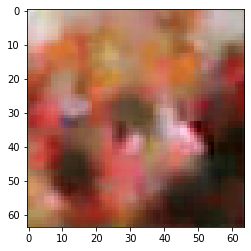

In [ ]:
out = ae(dataset[50]["image"].unsqueeze(0).cuda())

out = out.cpu().detach().permute(0, 2, 3, 1).numpy()
plt.imshow(out[0])


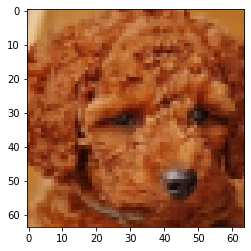

In [ ]:
img= dataset[50]["target"]
plt.imshow(img.permute(1,2, 0))
plt.show()

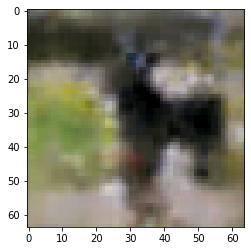

In [ ]:
out = ae(dataset[30]["image"].unsqueeze(0).cuda())

out = out.cpu().detach().permute(0, 2, 3, 1).numpy()
plt.imshow(out[0])


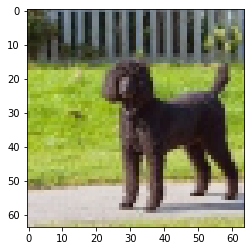

In [ ]:
img= dataset[30]["target"]
plt.imshow(img.permute(1,2, 0))
plt.show()